In [18]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import biomart
import os
import re
import matplotlib

import pandas as pd
import pickle as pkl
import numpy as np
import collections as cx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from goatools.go_search import GoSearch
from scipy import stats

from src.visualization.plots import psuedocontrolcomparisonplot, gene_sample_frequency_change_heatmap
from src.config import get_interim_dir
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE, SAMPLE, TARGET, get_experiment_artifacts
from skbio.stats.composition import clr

In [20]:
psuedo_controls = pd.read_csv(get_experiment_artifacts() + "/psuedo_controls.txt").rename(columns={"0": "Gene"})["Gene"]
psuedo_controls.shape

(100,)

In [21]:
get_experiment_artifacts()

'/Users/colm/repos/MUSICian/notebooks/exploratory/outlier_detection/artifacts/sample.robust_cov.700/'

In [22]:
outlier_details_df = pd.read_pickle(get_experiment_artifacts() + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik  0.340629        -0.250000  -0.420581                -0.362677   
0610010K14Rik -0.339087         0.464286  -0.593305                -0.183878   
0610030E20Rik -0.012887         0.035714  -0.334304                 0.194480   
0610040J01Rik  1.405359         0.107143   0.386962                -0.246977   
1110004F10Rik  1.223375        -0.178571   0.208164                -0.115229   
...                 ...              ...        ...                      ...   
Znhit1         0.550000         0.160714   0.225832                 0.962391   
Zranb2         1.278388         0.071429   0.495311                 0.745030   
Zrsr1          1.347381        -0.125000   0.240567                -1.200930   
Zup1           0.948928        -0.142857   0.206600                -0.312950   
Zwilch         1.850794         0.125000   0.324977                -0.603581   

Sample                                MB01                        MB02  \
Measure       Mean Std Consistency  Counts distances   pvalues  Counts   
Gene                                                                     
0610009B22Rik            -0.875111  2792.0  2.208519  0.819605  3122.0   
0610010K14Rik             0.856053  2320.5  1.027360  0.960329  2451.0   
0610030E20Rik            -0.151019  1638.0  9.058759  0.106743  2770.0   
0610040J01Rik             0.003445  1753.0  8.903629  0.112970  1798.0   
1110004F10Rik            -0.669054  1876.0  9.464008  0.091927  1929.0   
...                            ...     ...       ...       ...     ...   
Znhit1                    0.149099  1347.0       NaN       NaN     NaN   
Zranb2                   -0.070255     NaN       NaN       NaN  1180.0   
Zrsr1                    -0.521981     NaN       NaN       NaN  1339.5   
Zup1                     -0.567696  1292.5       NaN       NaN     NaN   
Zwilch                    0.059764     NaN       NaN       NaN     NaN   

Sample                    ...          T1              T2              \
Measure        distances  ... Consistency CLR Consistency Consistency   
Gene                      ...                                           
0610009B22Rik   2.124921  ...   -0.821429        0.392857    0.500000   
0610010K14Rik   0.854783  ...    0.678571       -0.321429    0.071429   
0610030E20Rik   4.471164  ...    0.464286        0.214286    0.071429   
0610040J01Rik  16.242836  ...    0.250000       -0.321429   -0.071429   
1110004F10Rik  17.195650  ...    0.107143       -0.071429   -0.214286   
...                  ...  ...         ...             ...         ...   
Znhit1               NaN  ...         NaN        0.714286    0.821429   
Zranb2               NaN  ...         NaN        0.321429   -0.178571   
Zrsr1                NaN  ...         NaN       -0.428571    0.250000   
Zup1                 NaN  ...         NaN       -0.107143   -0.107143   
Zwilch               NaN  ...         NaN        0.071429    0.285714   

Sample                     T3             Gene Sets              \
Measure       CLR Consistency Consistency   Adamson GeneSubset2   
Gene                                                              
0610009B22Rik        0.250000   -0.428571     False       False   
0610010K14Rik       -0.357143    0.642857     False       False   
0610030E20Rik        0.000000   -0.428571     False       False   
0610040J01Rik        0.285714    0.142857     False       False   
1110004F10Rik       -0.142857   -0.428571     False       False   
...                       ...         ...       ...         ...   
Znhit1               0.250000   -0.500000      True       False   
Zranb2               0.464286    0.321429     False       False   
Zrsr1               -0.428571   -0.500000     False       False   
Zup1           

In [23]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.capitalize()
genesubsetSD30 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubsetSD30.txt", sep="\t")["Gene"]
genesubset2 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubset2.txt", sep="\t")["Gene"]

In [24]:
lines = []
lines.append(' '.join(["Num Outliers", "Adamson Overlap", "Genesubset2 Overlap", "GenesubsetSD30 Overlap", "Overlap w/ GO DSB Repair\n"]))
for i in range(100, 2500, 400):
    out = outlier_details_df.sort_values(by=("Global", "Max Score"), ascending=False).iloc[:i,:]
    num_outliers = out.index.shape[0]
    num_adamson_overlap = np.intersect1d(out.index, hussmann_repair_genes).shape[0]
    num_genesubset2_overlap = np.intersect1d(out.index, genesubset2).shape[0]
    num_genesubsetSD30_overlap = np.intersect1d(out.index, genesubsetSD30).shape[0]
    num_GO_overlap = out.loc[:, ("Global", "isGORepair")].sum()
    num_GODSB_overlap = out.loc[:, ("Global", "isGODSBRepair")].sum()


    lines.append(' '.join([str(i), str(num_outliers), "{}/{}".format(num_adamson_overlap, len(hussmann_repair_genes)), \
        "{}/{}".format(num_genesubset2_overlap, len(genesubset2)), "{}/{}".format(num_genesubsetSD30_overlap, len(genesubsetSD30)), 
        "{}/{}".format(num_GO_overlap, outlier_details_df[("Global", "isGORepair")].sum()),
        "{}/{}\n".format(num_GODSB_overlap, outlier_details_df[("Global", "isGODSBRepair")].sum())]))

f = open(get_experiment_artifacts() + "/geneset_comparison_thresholded_by_numgenes_ranked_by_score.txt" ,'w')
f.writelines(lines)
f.close()

In [25]:
X_imputed = pkl.load(open(get_experiment_artifacts(profile_type=PROFILE_TYPE) + "/imputed_sample_data.pkl", "rb"))

print("Data Ready.")

Data Ready.


In [26]:
df = pd.concat(X_imputed.values(), keys=X_imputed.keys(), names=["Sample"])
print(df.shape)

outliers_df = df[df.index.get_level_values("Gene").isin(outlier_details_df.index)]
print(outliers_df.shape)

psudo_control_df = df.loc[df.index.get_level_values("Gene").isin(psuedo_controls), :]
psudo_control_gmean_df = pd.DataFrame(psudo_control_df.groupby("Sample").apply(stats.gmean).values.tolist(), index=X_imputed.keys(), columns=df.columns)
psudo_control_gmean_df.index.name="Sample"
psudo_control_gmean_df

psudo_control_gmean_df = psudo_control_gmean_df.div(psudo_control_gmean_df.sum(axis=1), axis=0)

print(psudo_control_gmean_df.shape)

change_df = outliers_df - psudo_control_gmean_df
change_df
print(change_df.shape)

(104800, 7)
(104800, 7)
(6, 7)
(104800, 7)


In [27]:
clr_change_df = {}

for a in X_imputed.keys():
    clrcdf = outliers_df.loc[a, :] .dropna(axis=1)
    clrcdf = pd.DataFrame(clr(clrcdf), index=clrcdf.index, columns=clrcdf.columns)
    clr_change_df[a] = (clrcdf - clr(psudo_control_gmean_df.loc[a, :].dropna()))

clr_change_df = pd.concat(clr_change_df)

In [28]:
ranked_outlier_df = outlier_details_df.sort_values(by=("Global", "Mean Score"), ascending=False)["Global"]
outlier_genes = ranked_outlier_df.index.to_series().iloc[:500]
outlier_genes.index
print(outlier_genes.shape[0])

500


In [29]:
genesubset2 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubset2.txt", sep="\t")["Gene"]


In [30]:
all_included = sorted(genesubset2[np.isin(genesubset2, outlier_genes)])

print(all_included)
print(len(all_included))


['Bard1', 'Dbr1', 'Faap100', 'Fanca', 'Fancb', 'Fancc', 'Fancd2', 'Fancg', 'Fanci', 'Fancl', 'Fancm', 'Helq', 'Lig4', 'Mad2l2', 'Mre11a', 'Nbn', 'Poll', 'Polq', 'Rad50', 'Rad51', 'Rnf168', 'Rnf8', 'Tonsl', 'Ube2t', 'Xrcc5', 'Xrcc6']
26


In [31]:
all_excluded = sorted(genesubset2[~np.isin(genesubset2, outlier_genes)])

print(all_excluded)

['Brca1', 'Brca2', 'Ctc1', 'Dut', 'H2afx', 'H2afx', 'Hus1', 'Mettl14', 'Mettl3', 'Paxip1', 'Polm', 'Prkdc', 'Rad17', 'Rad51ap1', 'Rad52', 'Rad54', 'Rbbp8', 'Rif1', 'Shld2', 'Stn1', 'Ten1', 'Trp53', 'Trp53bp1', 'Usp1', 'Wdr48', 'Xrcc4']


### The problem child - 4921524J17Rik

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


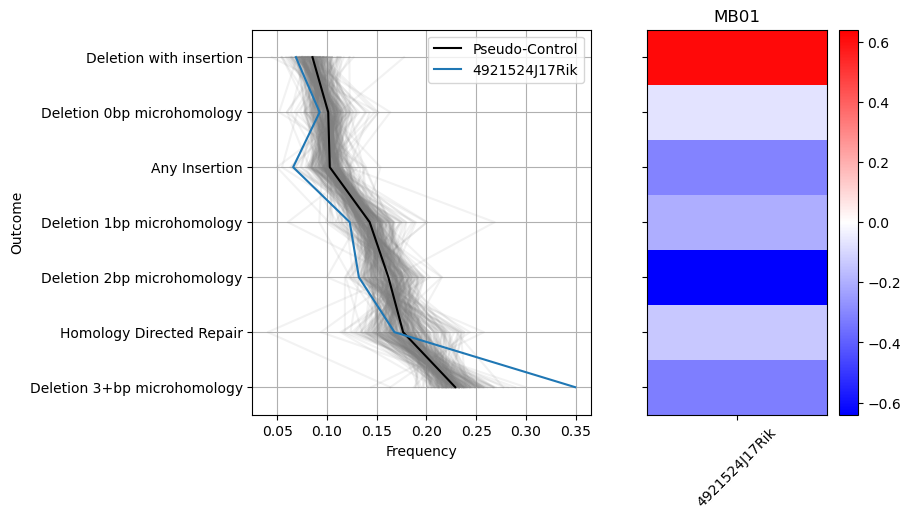

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


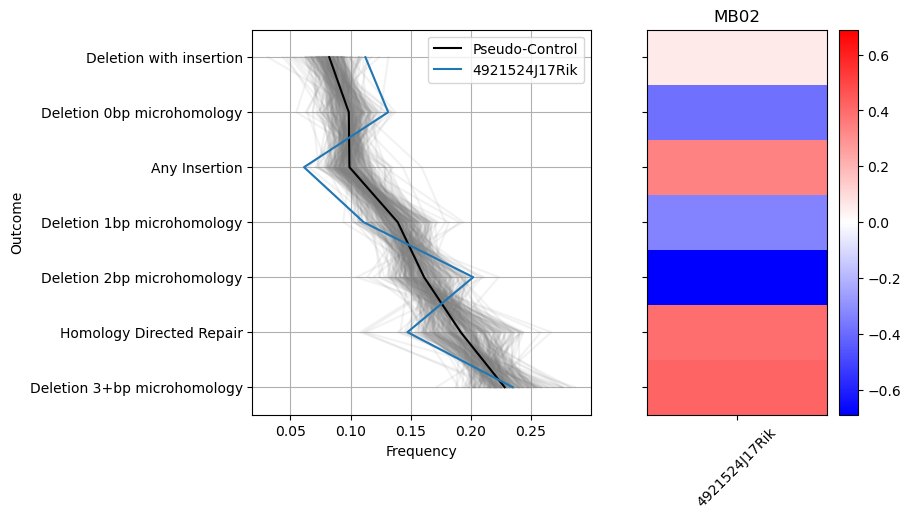

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


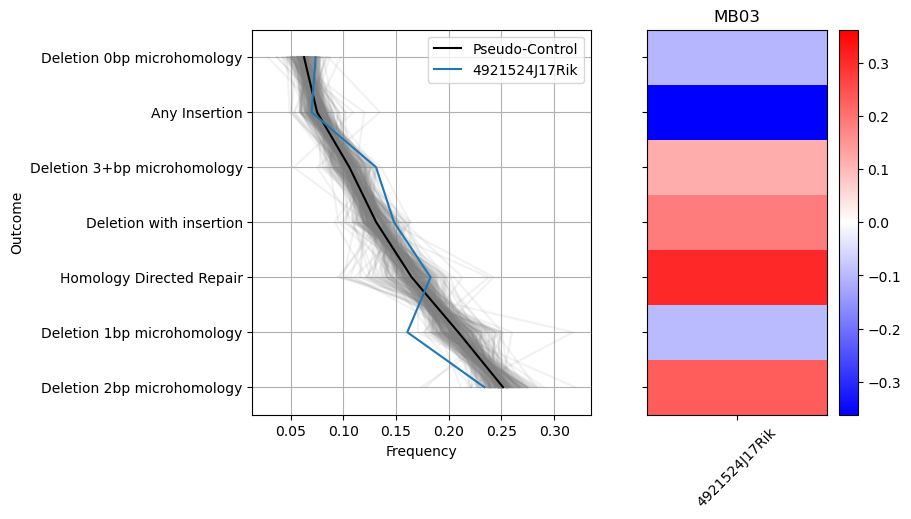

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


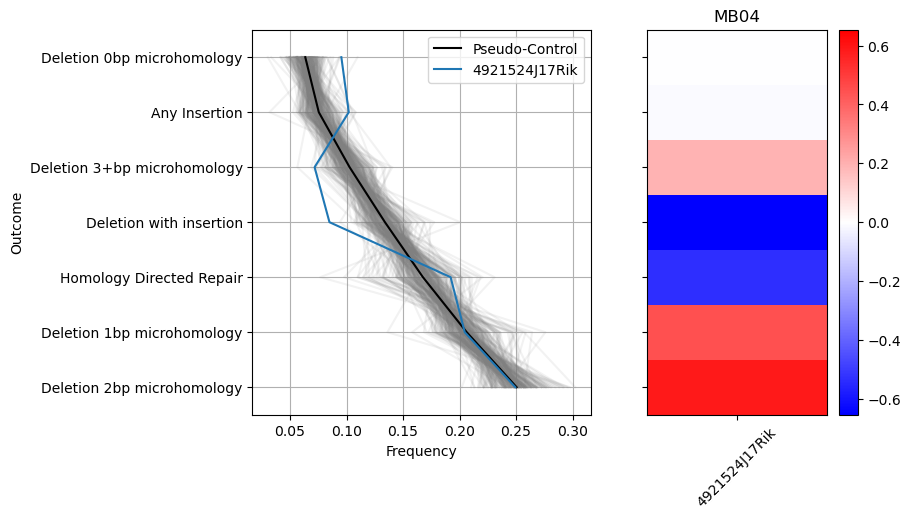

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


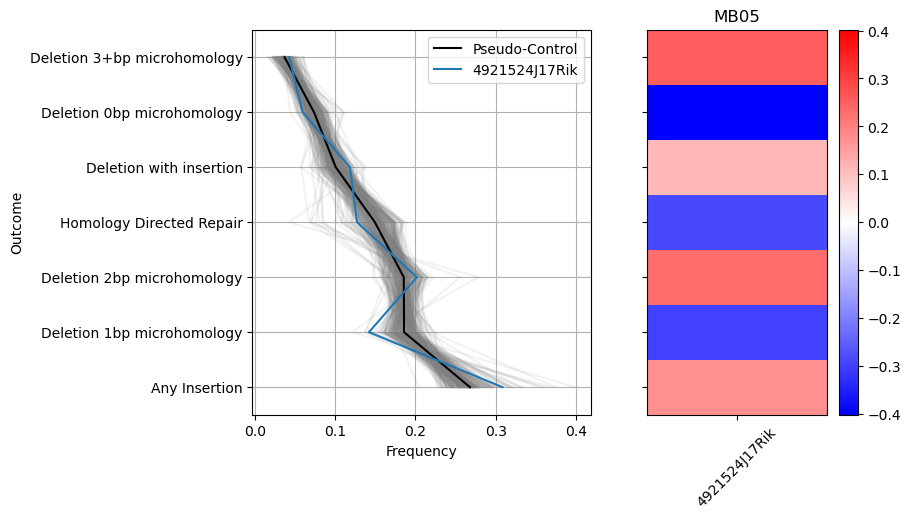

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


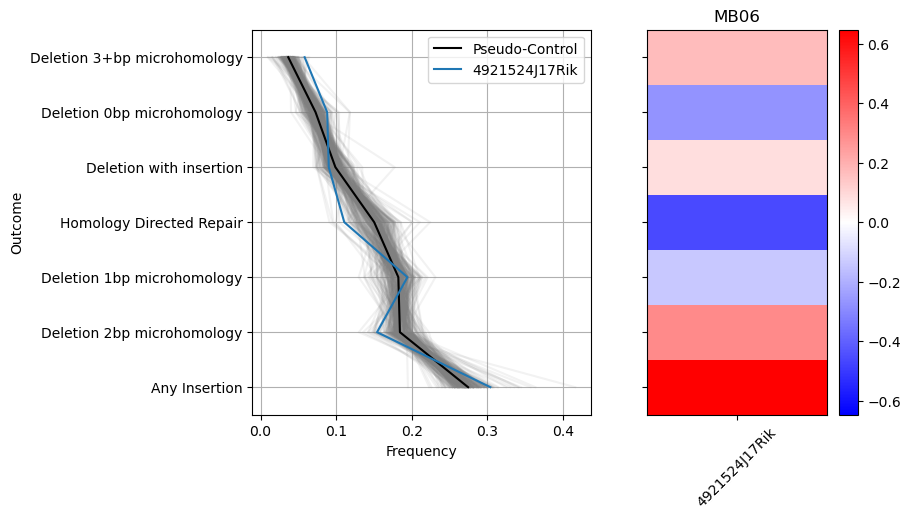

In [33]:
for sample in X_imputed.keys():
    psuedocontrolcomparisonplot( 
        df.loc[sample].dropna(axis=1), 
        pseudo_controls = psuedo_controls,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_numpy(), ["4921524J17Rik"]), 
        num_outcomes=40)
    plt.title(sample)
    plt.show()

In [34]:
outlier_details_df["Global"].columns

Index(['Max Score', 'Mean Consistency', 'Mean Score',
       'Mean Std CLR Consistency', 'Mean Std Consistency', 'isGODSBRepair',
       'isGORepair'],
      dtype='object', name='Measure')

### Most Consistent Genes

In [35]:
consistent_genes = outlier_details_df.sort_values(by=("Global", "Mean Consistency"), ascending=False).index.to_list()[:5]

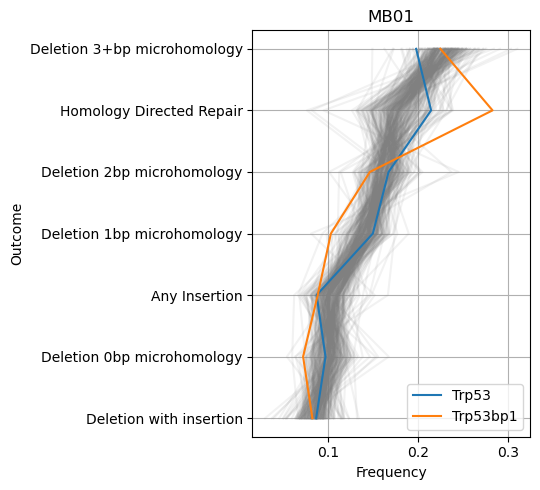

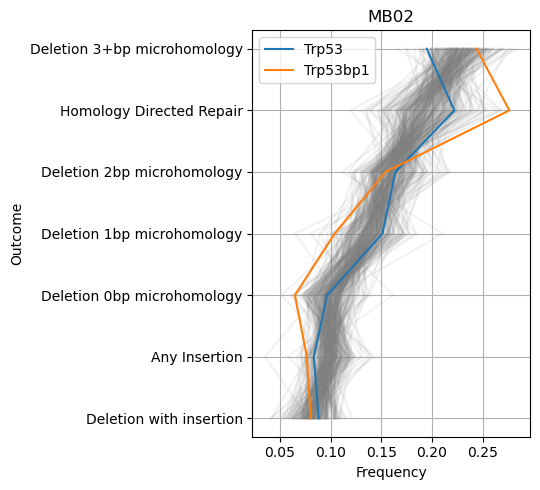

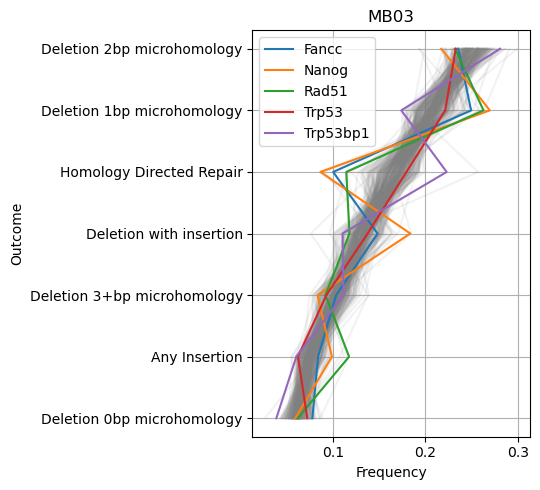

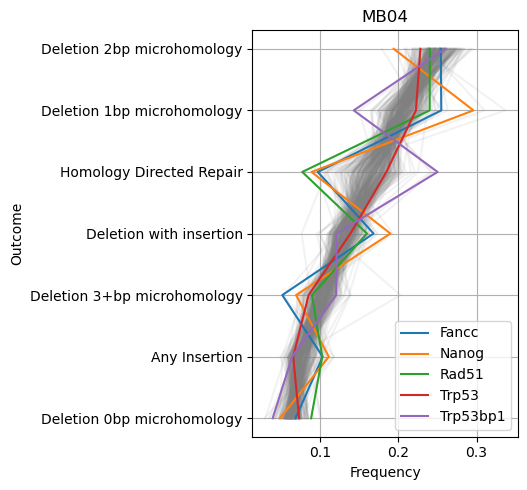

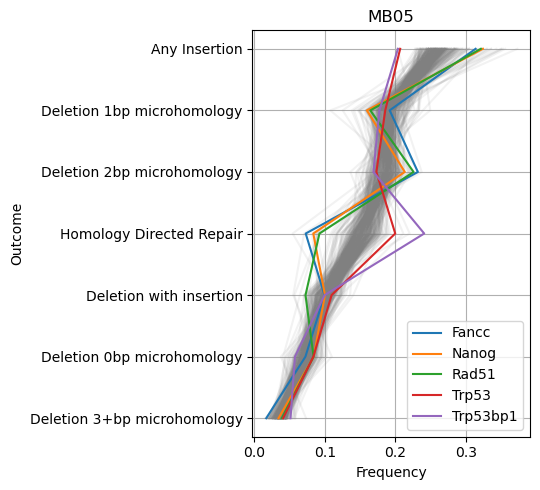

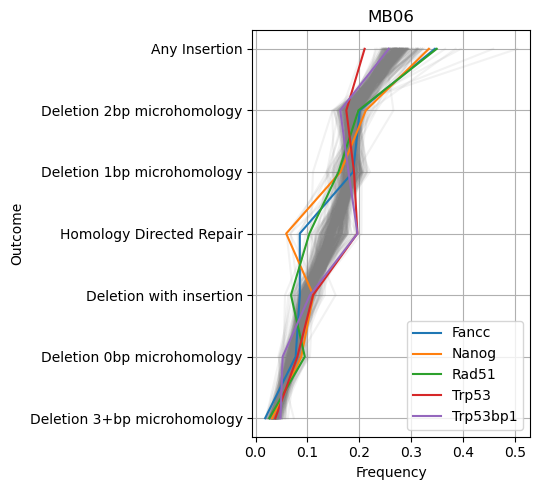

In [36]:
for sample in X_imputed.keys():
    psuedocontrolcomparisonplot( 
        df.loc[sample].dropna(axis=1), 
        pseudo_controls = None,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_numpy(), consistent_genes), 
        num_outcomes=40, include_heatmap=False)
    plt.title(sample)
    plt.tight_layout()
    plt.savefig(get_experiment_artifacts() + "consistent_genes.{}.pdf".format(sample))

### Least Consistent Genes

In [37]:
inconsistent_genes = outlier_details_df.sort_values(by=("Global", "Mean Consistency"), ascending=True).index.to_list()[:5]

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


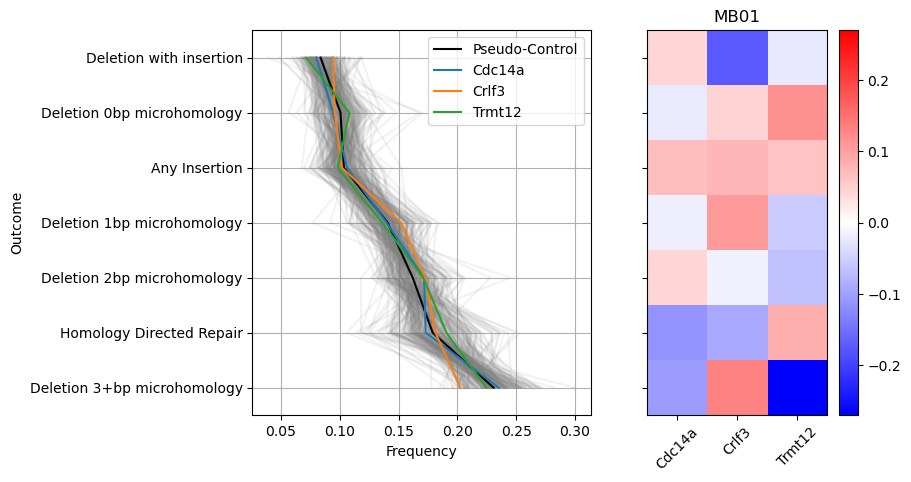

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


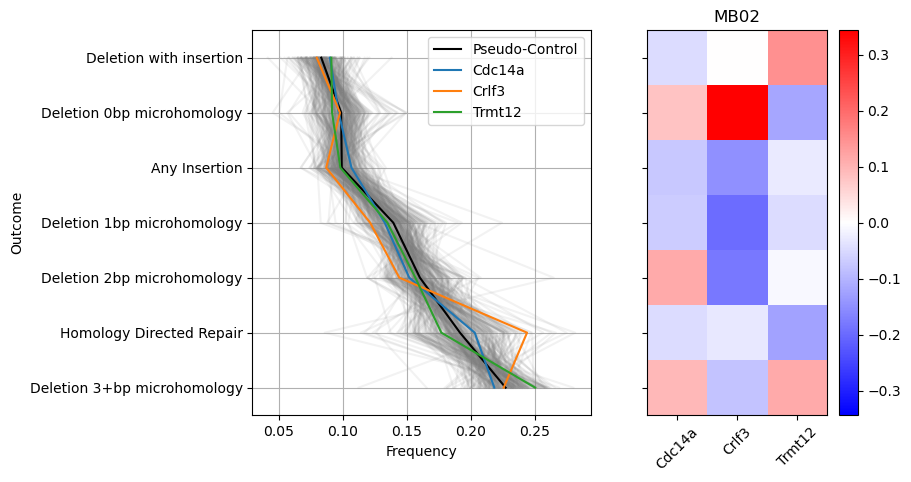

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


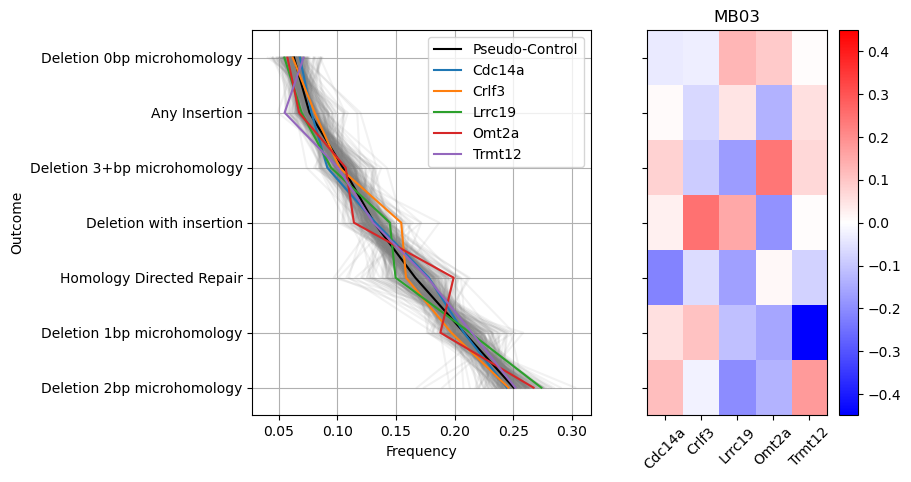

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


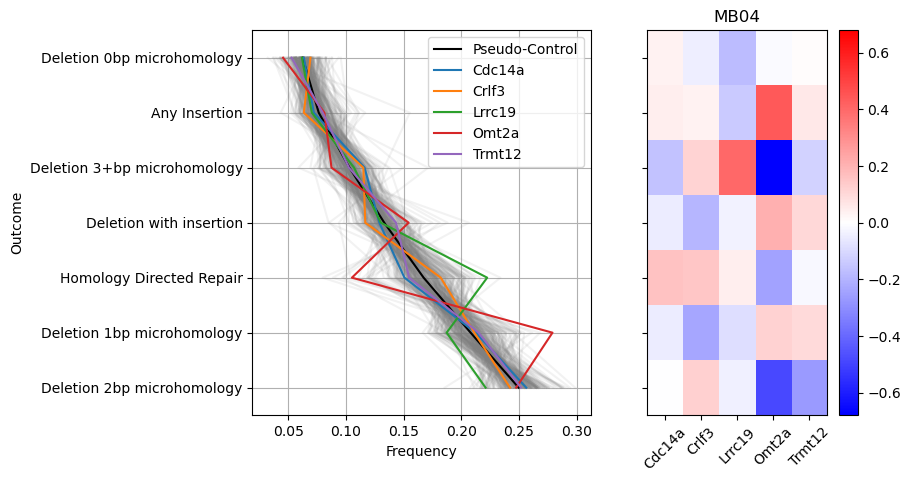

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


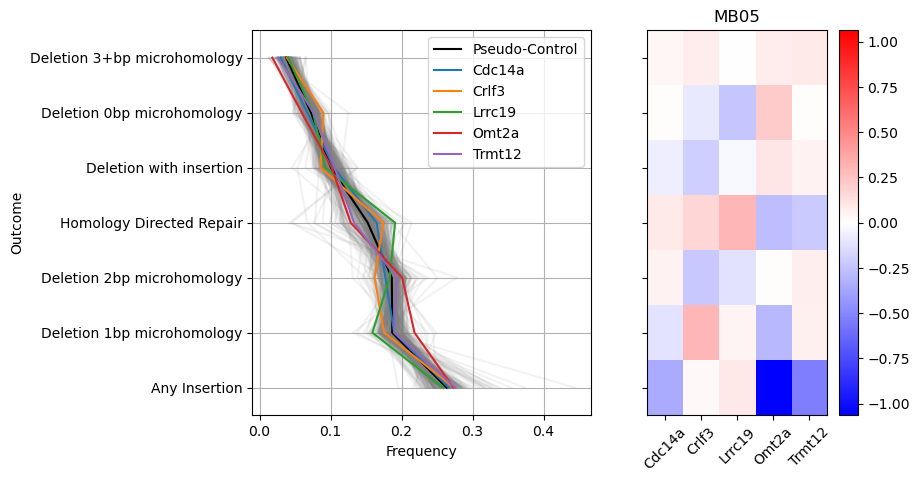

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


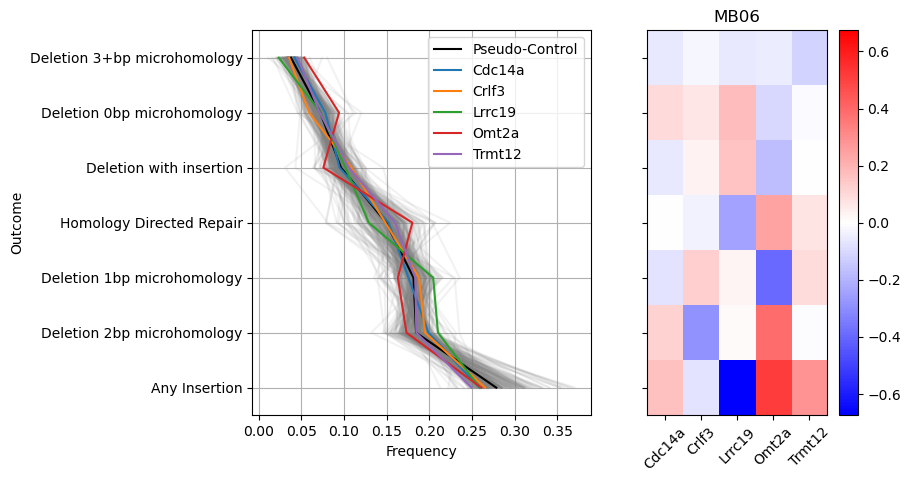

In [38]:
for sample in X_imputed.keys():
    psuedocontrolcomparisonplot( 
        df.loc[sample].dropna(axis=1), 
        pseudo_controls = psuedo_controls,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_numpy(), inconsistent_genes), 
        num_outcomes=40)
    plt.title(sample)
    plt.show()

In [76]:
outlier_details_df.sort_values(by=("Global", "Mean Score"), ascending=False).iloc[300:305][("Global", "Mean Std Consistency")]

Gene
Pam16      0.440895
Cenph     -0.115488
Polr1d     1.103297
Crnkl1    -0.120666
Mettl16    1.055493
Name: (Global, Mean Std Consistency), dtype: float64

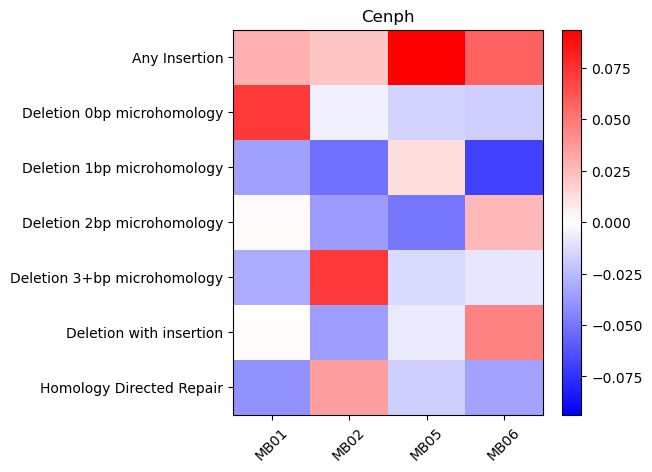

In [77]:
gene_sample_frequency_change_heatmap(change_df, "Cenph", counts=None)

lumc_category         Deletion 0bp microhomology  Deletion 1bp microhomology  \
Sample Gene                                                                    
MB03   0610009B22Rik                    0.000879                   -0.003833   
       0610010K14Rik                    0.005288                   -0.003891   
       0610030E20Rik                   -0.005963                    0.006252   
       0610040J01Rik                   -0.010890                   -0.008971   
       1110004F10Rik                   -0.010020                   -0.006661   
...                                          ...                         ...   
MB04   Zzef1                            0.002384                   -0.004282   
       Zzz3                            -0.003486                    0.008941   
       a                               -0.004056                    0.007423   
       ccdc198                          0.000276                    0.021226   
       mei-04                          -0.001955                   -0.012046   

lumc_category         Deletion 2bp microhomology  Deletion with insertion  \
Sample Gene                                                                 
MB03   0610009B22Rik                    0.004452                -0.007162   
       0610010K14Rik                    0.002120                -0.003847   
       0610030E20Rik                    0.007429                 0.011479   
       0610040J01Rik                    0.001730                -0.011869   
       1110004F10Rik                   -0.004656                 0.012881   
...                                          ...                      ...   
MB04   Zzef1                           -0.029924                 0.009529   
       Zzz3                            -0.009382                 0.011833   
       a                               -0.026970                -0.010925   
       ccdc198                         -0.014803                 0.006368   
       mei-04                           0.009326                 0.015960   

lumc_category         Homology Directed Repair  Any Insertion  \
Sample Gene                                                     
MB03   0610009B22Rik                  0.001463       0.004102   
       0610010K14Rik                 -0.002684       0.005500   
       0610030E20Rik                 -0.011528       0.001293   
       0610040J01Rik                  0.016443       0.003125   
       1110004F10Rik                 -0.011976       0.003794   
...                                        ...            ...   
MB04   Zzef1                          0.010624      -0.007808   
       Zzz3                          -0.003943       0.013653   
       a                              0.024080       0.020652   
       ccdc198                       -0.000204       0.003078   
       mei-04                        -0.006960       0.003226   

lumc_category         Deletion 3+bp microhomology  
Sample Gene                                        
MB03   0610009B22Rik                     0.000099  
       0610010K14Rik                    -0.002485  
       0610030E20Rik                    -0.008962  
       0610040J01Rik                     0.010432  
       1110004F10Rik                     0.016638  
...                                           ...  
MB04   Zzef1                             0.019478  
       Zzz3                             -0.017617  
       a                                -0.010204  
       ccdc198                          -0.015941  
       mei-04                           -0.007551  

[35886 rows x 7 columns]

/Users/colm/repos/MUSICian/src/visualization/plots.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


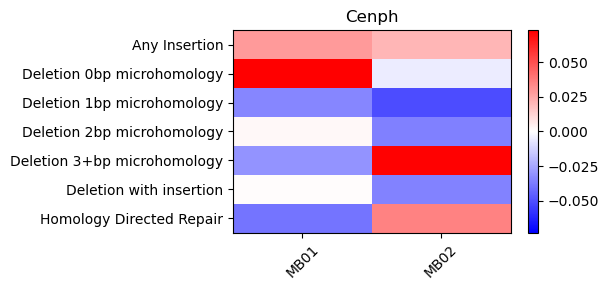

In [79]:
gene_sample_frequency_change_heatmap(change_df.loc[["MB01", "MB02"]], "Cenph", counts=None, figsize=(6, 3))
plt.tight_layout()
plt.savefig(get_experiment_artifacts() + "Cenph.MB01_MB02.pdf")

In [40]:
np.random.seed(0)
sorted(np.random.choice(genesubset2[np.isin(genesubset2, outlier_genes)], 5))

['Faap100', 'Fancc', 'Lig4', 'Mad2l2', 'Ube2t']

### Genes included in both sets

Included examples ['Faap100', 'Fancc', 'Lig4', 'Mad2l2', 'Ube2t']


/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


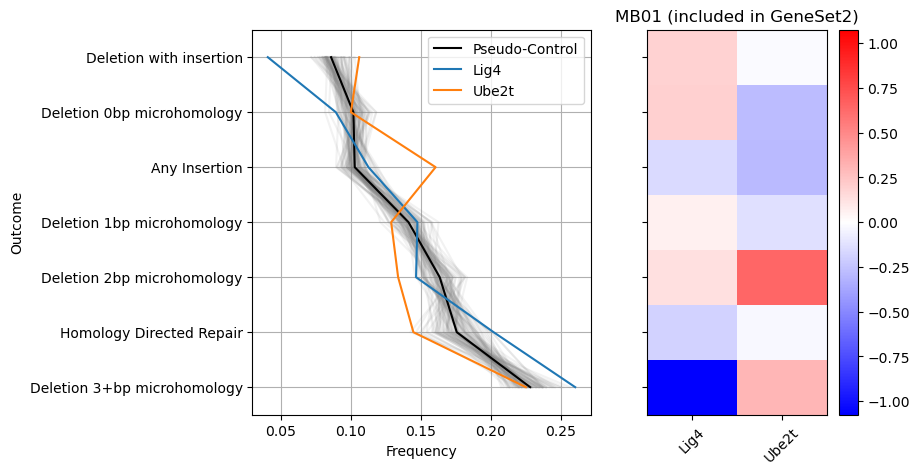

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


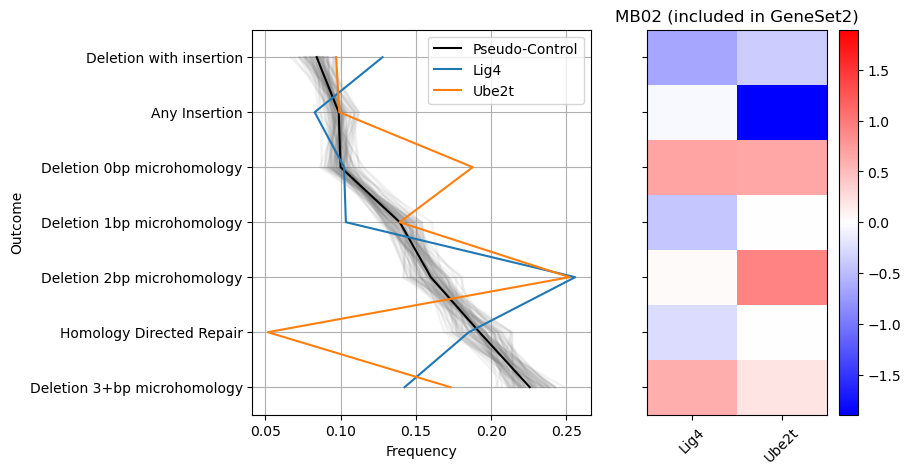

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


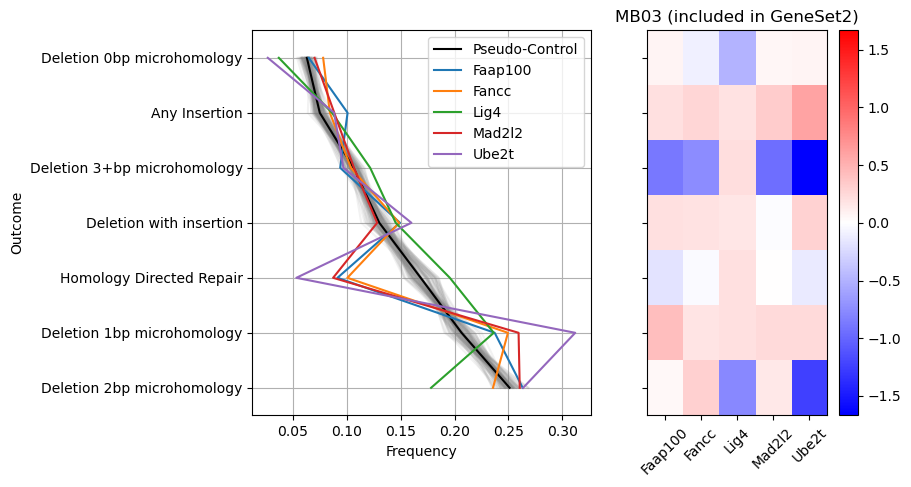

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


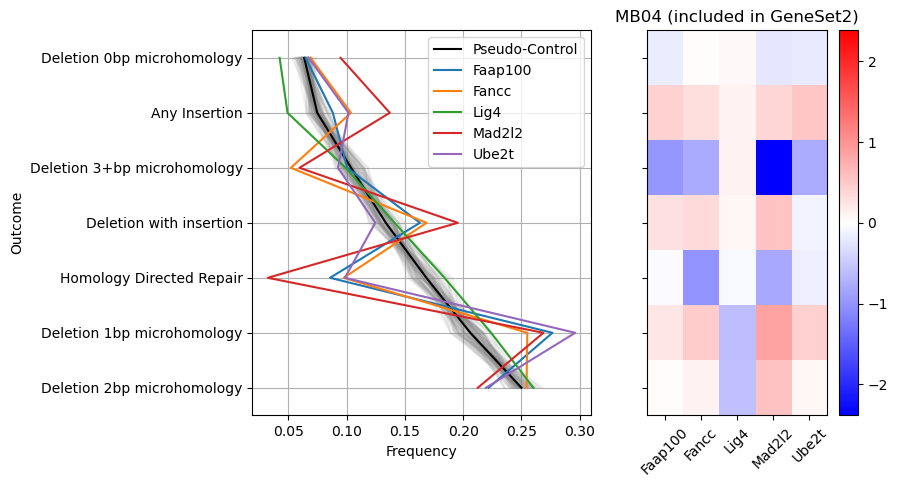

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


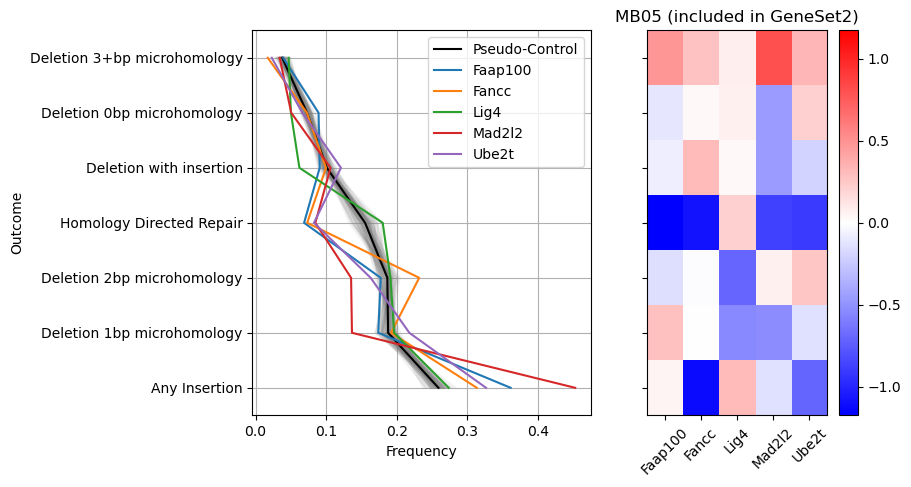

/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


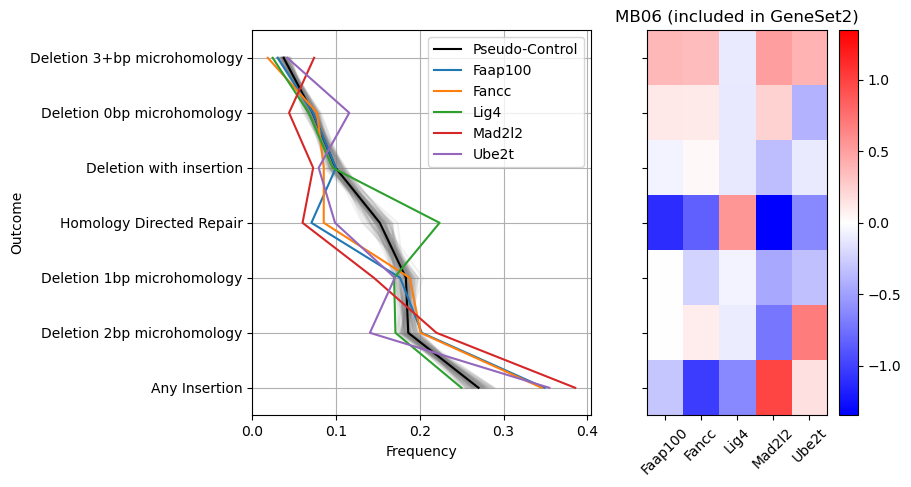

In [41]:
np.random.seed(0)
gene_list_included = sorted(np.random.choice(genesubset2[np.isin(genesubset2, outlier_genes)], 5))
print("Included examples", gene_list_included)
# gene_list_excluded = ['Lig4', 'H2afx', 'Brca2', 'Tonsl', 'Rad54']
for sample in X_imputed.keys():
    psuedocontrolcomparisonplot( 
        df.loc[sample].dropna(axis=1), 
        pseudo_controls = psuedo_controls,
        # background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_numpy(), gene_list_included), 
        num_outcomes=40)
    plt.title(sample + " (included in GeneSet2)")
    plt.show()   

Excluded examples ['Brca1', 'Brca2', 'Ctc1', 'Dut', 'H2afx', 'H2afx', 'Hus1', 'Mettl14', 'Mettl3', 'Paxip1', 'Polm', 'Prkdc', 'Rad17', 'Rad51ap1', 'Rad52', 'Rad54', 'Rbbp8', 'Rif1', 'Shld2', 'Stn1', 'Ten1', 'Trp53', 'Trp53bp1', 'Usp1', 'Wdr48', 'Xrcc4']


/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
/Users/colm/repos/MUSICian/src/visualization/plots.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)
/Users/colm/repos/MUSICian/src/visualization/plots.py:1

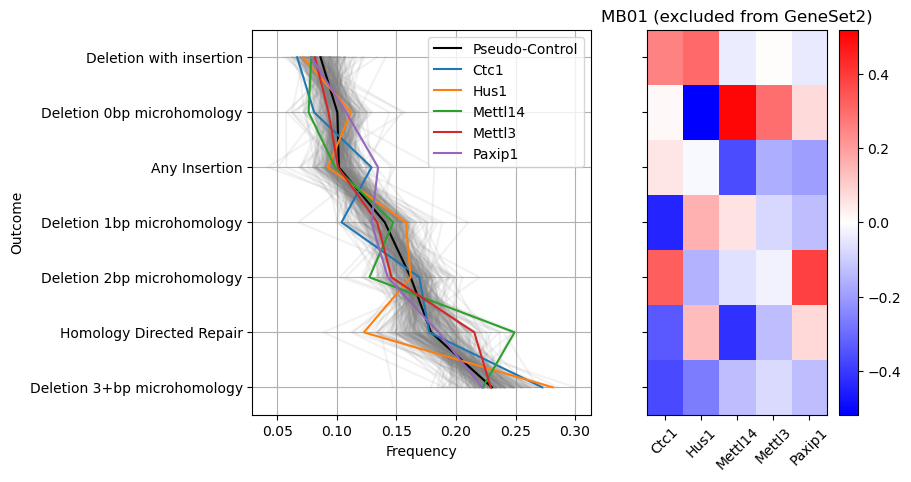

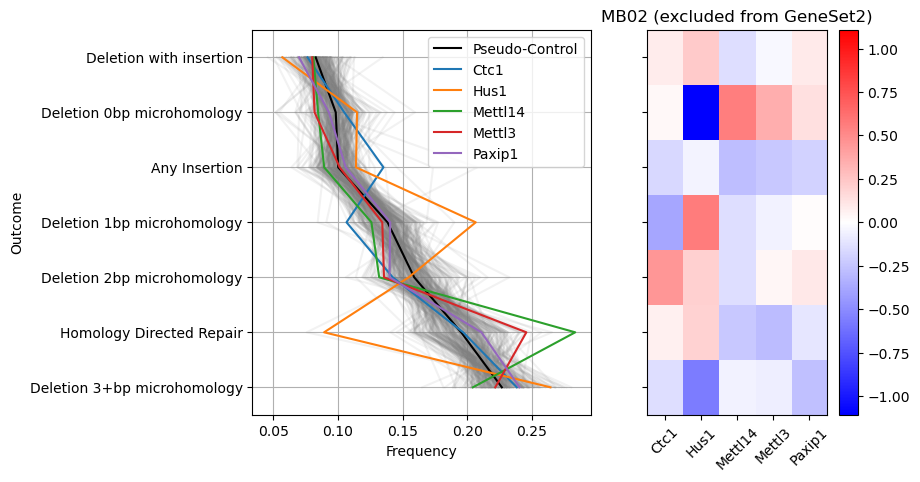

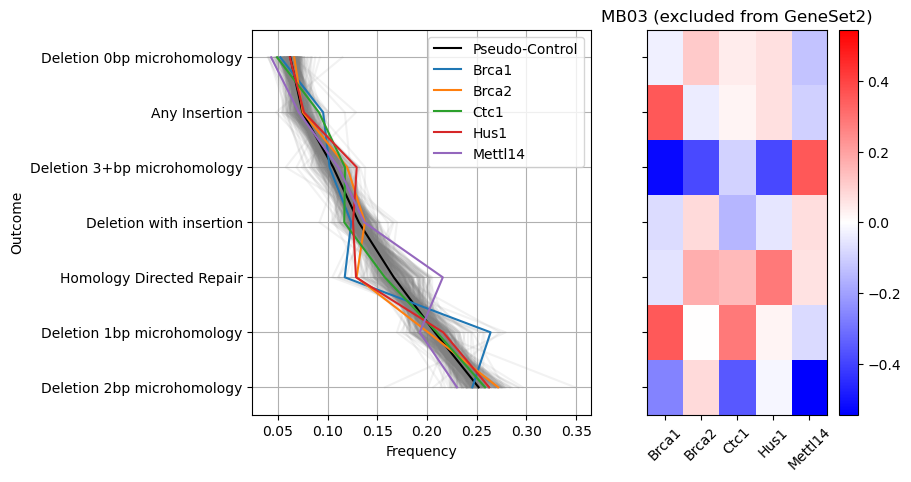

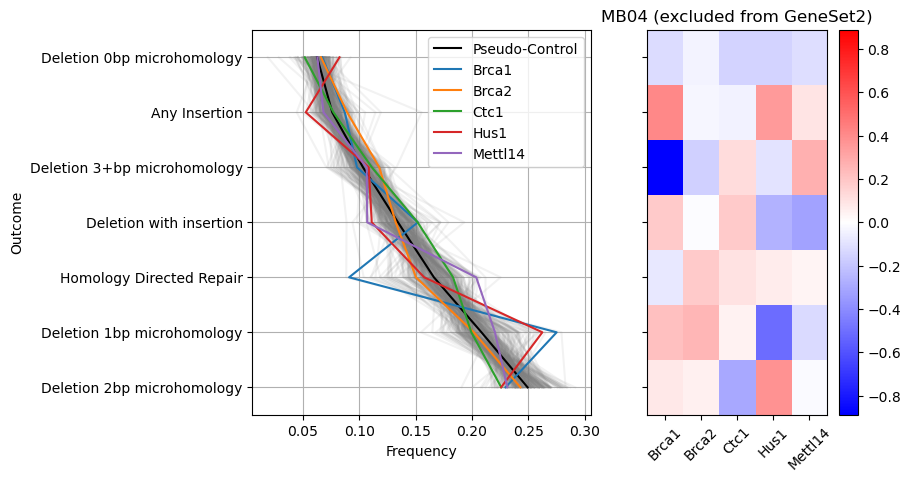

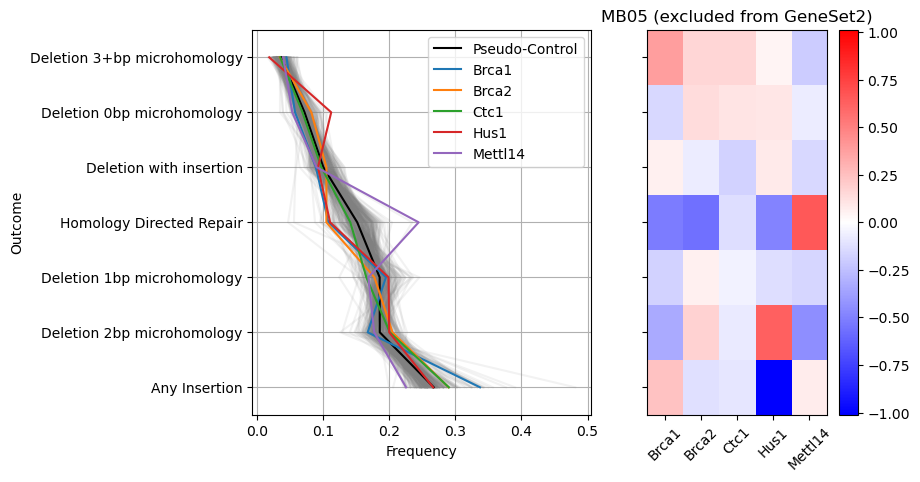

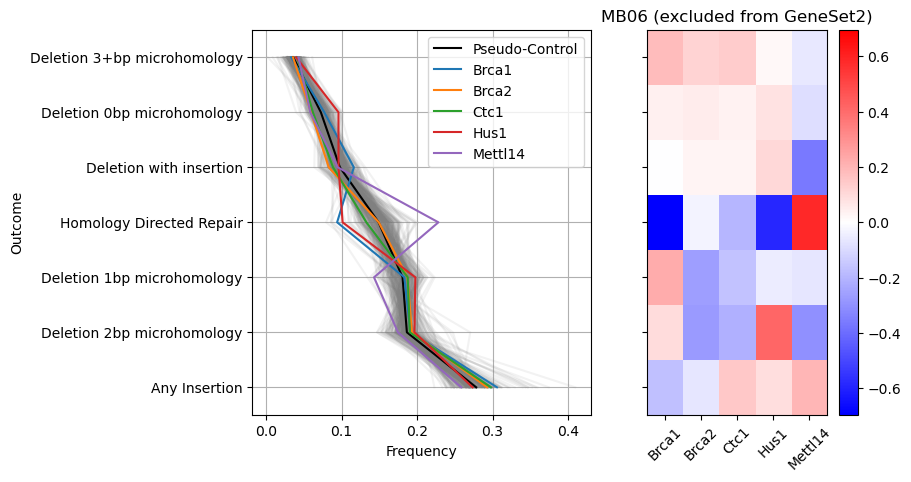

In [42]:
np.random.seed(0)
gene_list_excluded = sorted(all_excluded)

# gene_list_excluded = ["Tonsl", "Lig4", "Brca2"]
print("Excluded examples", gene_list_excluded)

# for sample in X_imputed.keys():
#     psuedocontrolcomparisonplot( 
#         df.loc[sample].dropna(axis=1), 
#         pseudo_controls = psuedo_controls,
#         compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_list(), 
#         gene_list_excluded), num_outcomes=40)
#     plt.title(sample + " (excluded from GeneSet2)")

for sample in X_imputed.keys():
    psuedocontrolcomparisonplot( 
        df.loc[sample].dropna(axis=1), 
        pseudo_controls = psuedo_controls,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_numpy(), gene_list_excluded)[:5], 
        num_outcomes=40)
    plt.title(sample + " (excluded from GeneSet2)")

In [43]:
print(outlier_details_df.loc[np.intersect1d(gene_list_excluded, outlier_details_df.index)].xs("pvalues", level="Measure", axis=1))

Sample            MB01          MB02          MB03          MB04  \
Gene                                                               
Brca1              NaN           NaN  2.394896e-06  1.753999e-09   
Brca2              NaN           NaN  2.822612e-02  3.452074e-01   
Ctc1      1.175246e-04  5.455461e-03  3.249458e-02  1.483342e-01   
Hus1      2.256149e-03  8.182344e-14  1.175987e-02  5.658768e-06   
Mettl14   5.034862e-03  7.079009e-03  1.835818e-03  3.699878e-02   
Mettl3    5.850896e-01  1.321125e-01  1.960008e-02  4.573816e-03   
Paxip1    8.478348e-02  3.944974e-01  9.489139e-02  4.574701e-02   
Polm      8.536800e-02  6.375091e-01  1.645101e-08  5.258027e-11   
Prkdc     1.765138e-02  4.265466e-03  5.360268e-05  5.244055e-05   
Rad17              NaN           NaN  5.149614e-04  3.027769e-05   
Rad51ap1  1.020384e-03  7.416835e-06  1.556488e-10  4.485421e-07   
Rad52     2.426516e-02  8.549070e-08  9.891565e-02  3.437817e-01   
Rbbp8              NaN           NaN  3.155204e-

In [44]:
outlier_details_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik  0.340629        -0.250000  -0.420581                -0.362677   
0610010K14Rik -0.339087         0.464286  -0.593305                -0.183878   
0610030E20Rik -0.012887         0.035714  -0.334304                 0.194480   
0610040J01Rik  1.405359         0.107143   0.386962                -0.246977   
1110004F10Rik  1.223375        -0.178571   0.208164                -0.115229   
...                 ...              ...        ...                      ...   
Znhit1         0.550000         0.160714   0.225832                 0.962391   
Zranb2         1.278388         0.071429   0.495311                 0.745030   
Zrsr1          1.347381        -0.125000   0.240567                -1.200930   
Zup1           0.948928        -0.142857   0.206600                -0.312950   
Zwilch         1.850794         0.125000   0.324977                -0.603581   

Sample                                MB01                        MB02  \
Measure       Mean Std Consistency  Counts distances   pvalues  Counts   
Gene                                                                     
0610009B22Rik            -0.875111  2792.0  2.208519  0.819605  3122.0   
0610010K14Rik             0.856053  2320.5  1.027360  0.960329  2451.0   
0610030E20Rik            -0.151019  1638.0  9.058759  0.106743  2770.0   
0610040J01Rik             0.003445  1753.0  8.903629  0.112970  1798.0   
1110004F10Rik            -0.669054  1876.0  9.464008  0.091927  1929.0   
...                            ...     ...       ...       ...     ...   
Znhit1                    0.149099  1347.0       NaN       NaN     NaN   
Zranb2                   -0.070255     NaN       NaN       NaN  1180.0   
Zrsr1                    -0.521981     NaN       NaN       NaN  1339.5   
Zup1                     -0.567696  1292.5       NaN       NaN     NaN   
Zwilch                    0.059764     NaN       NaN       NaN     NaN   

Sample                    ...          T1              T2              \
Measure        distances  ... Consistency CLR Consistency Consistency   
Gene                      ...                                           
0610009B22Rik   2.124921  ...   -0.821429        0.392857    0.500000   
0610010K14Rik   0.854783  ...    0.678571       -0.321429    0.071429   
0610030E20Rik   4.471164  ...    0.464286        0.214286    0.071429   
0610040J01Rik  16.242836  ...    0.250000       -0.321429   -0.071429   
1110004F10Rik  17.195650  ...    0.107143       -0.071429   -0.214286   
...                  ...  ...         ...             ...         ...   
Znhit1               NaN  ...         NaN        0.714286    0.821429   
Zranb2               NaN  ...         NaN        0.321429   -0.178571   
Zrsr1                NaN  ...         NaN       -0.428571    0.250000   
Zup1                 NaN  ...         NaN       -0.107143   -0.107143   
Zwilch               NaN  ...         NaN        0.071429    0.285714   

Sample                     T3             Gene Sets              \
Measure       CLR Consistency Consistency   Adamson GeneSubset2   
Gene                                                              
0610009B22Rik        0.250000   -0.428571     False       False   
0610010K14Rik       -0.357143    0.642857     False       False   
0610030E20Rik        0.000000   -0.428571     False       False   
0610040J01Rik        0.285714    0.142857     False       False   
1110004F10Rik       -0.142857   -0.428571     False       False   
...                       ...         ...       ...         ...   
Znhit1               0.250000   -0.500000      True       False   
Zranb2               0.464286    0.321429     False       False   
Zrsr1               -0.428571   -0.500000     False       False   
Zup1           